#Hybrid model for time series forecasting

##Data preprocessing

In [1]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import drive
from scipy.stats import normaltest
import statsmodels.api as sm

Close prices

[*********************100%***********************]  1 of 1 completed


ADF Statistic: 2.9706652265254334
P-value: 1.0
Normal test Statistic: 1017.341
P-value: 0.000


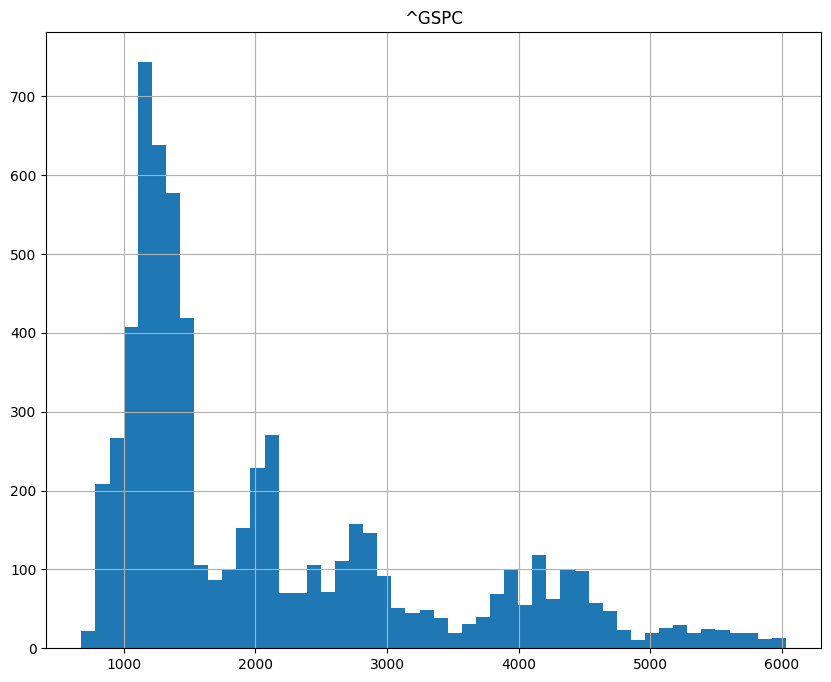

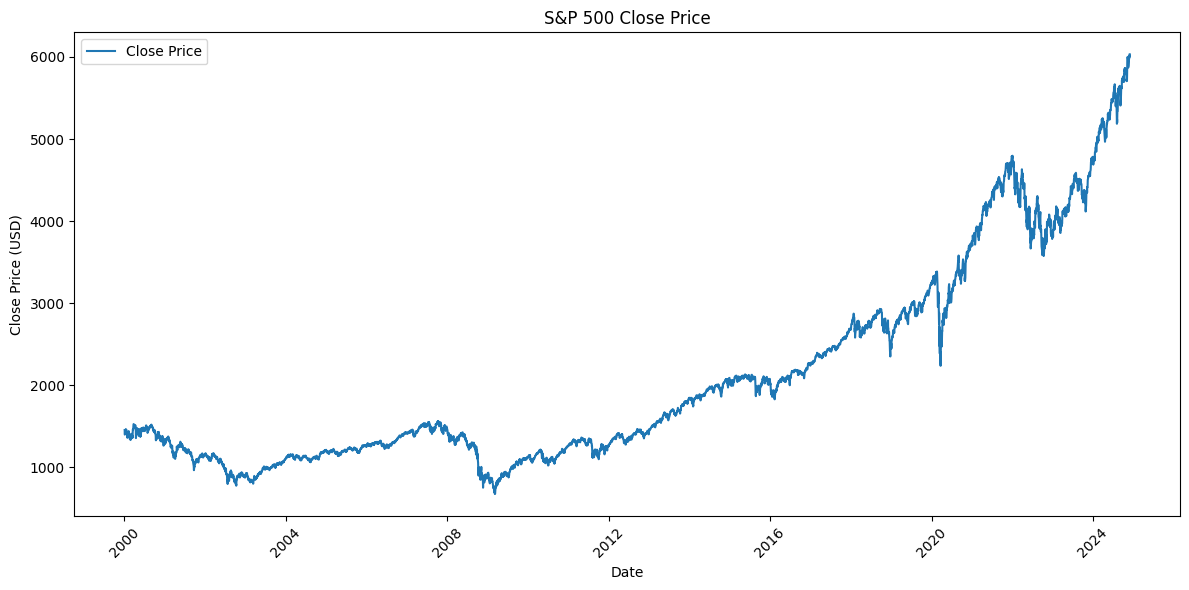

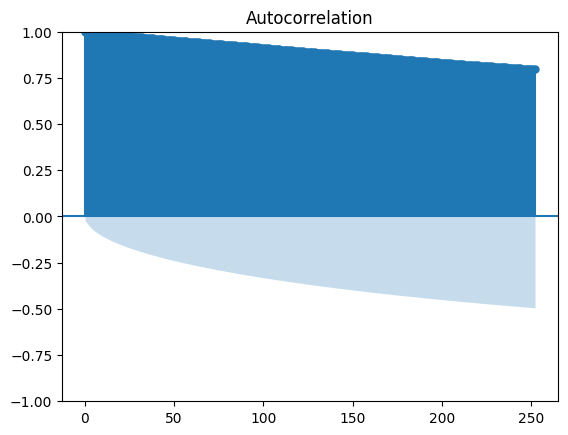

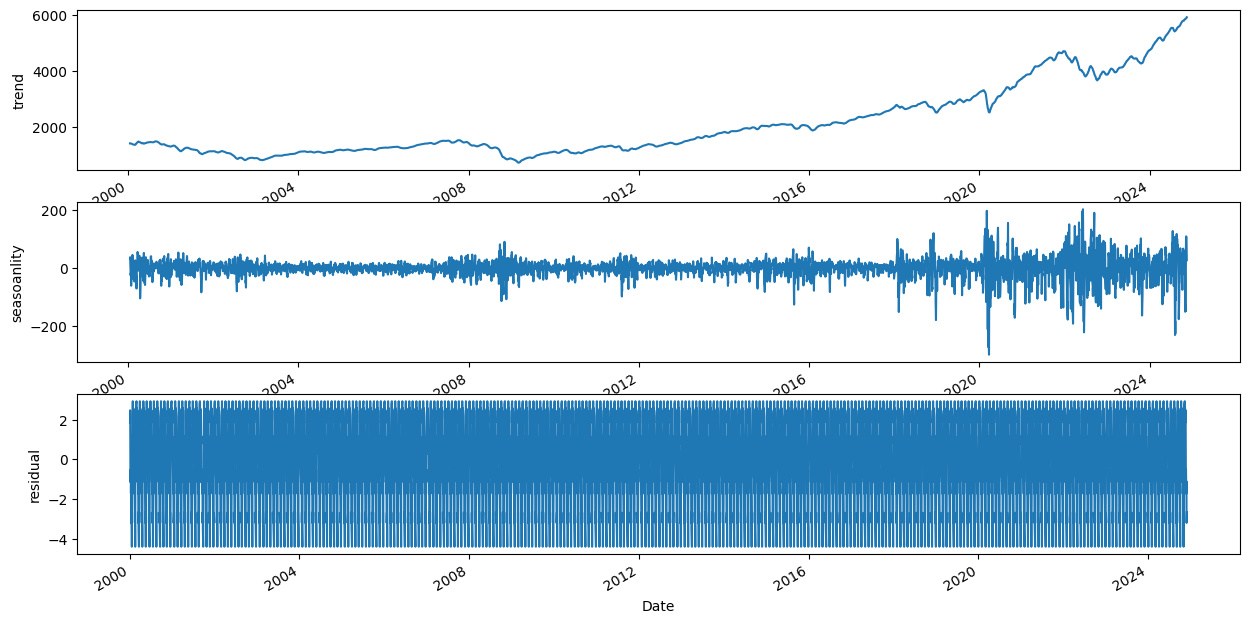

In [2]:
#import financial time series
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
sp500_data = yf.download(ticker, start = start_date, end = end_date, interval="1d")
sp500_data.index = sp500_data.index.tz_localize(None)
# sp500_close = sp500_data['Close']
# sp500_close.head()


#test stationarity with the Augmented Dickey-Fuller (ADF) test
result = adfuller(sp500_data['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary


#test normality with Normality test
stat, p = normaltest(sp500_data['Close'])
print(f"Normal test Statistic: {stat[0]:.3f}")
print(f"P-value: {p[0]:.3f}") # If the p-value is more than 0.05, the series is normally distributed


#visualise

sp500_data['Close'].hist(bins=50, figsize=(10, 8))
plt.show()


plt.figure(figsize=(12, 6))
# sns.lineplot(x=sp500_close.index, y=sp500_close.values, label="S&P 500 Close Price")
sns.lineplot(data=sp500_data['Close'])
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend( labels=["Close Price"])
plt.show()


#plot autocorrelation
plot_acf(sp500_data['Close'], lags=252)
plt.show()


#decompose time series
res = seasonal_decompose(sp500_data['Close'], model = "additive",period = 21)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

Log returns

Mounted at /content/gdrive
ADF Statistic: -19.033157765306733
P-value: 0.0
Normal test Statistic: 1017.341
P-value: 0.000


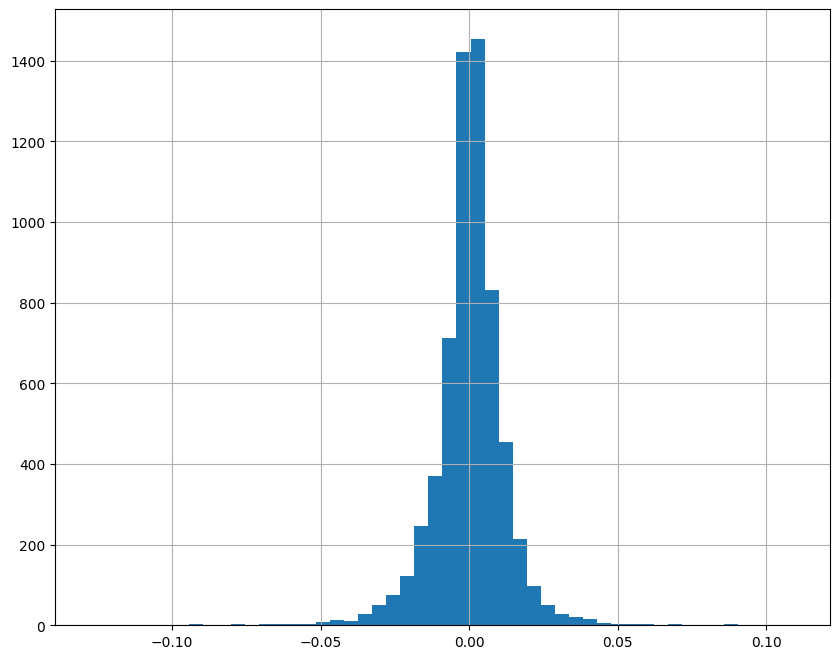

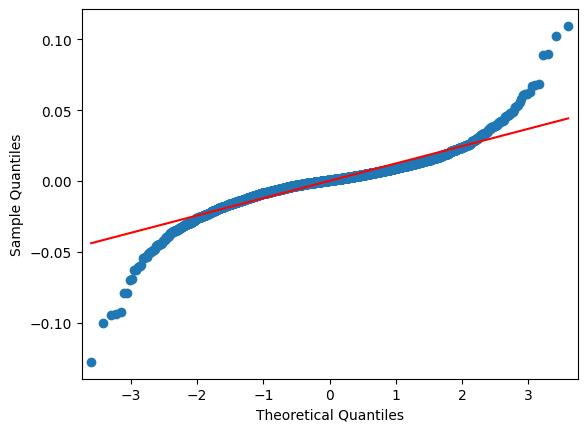

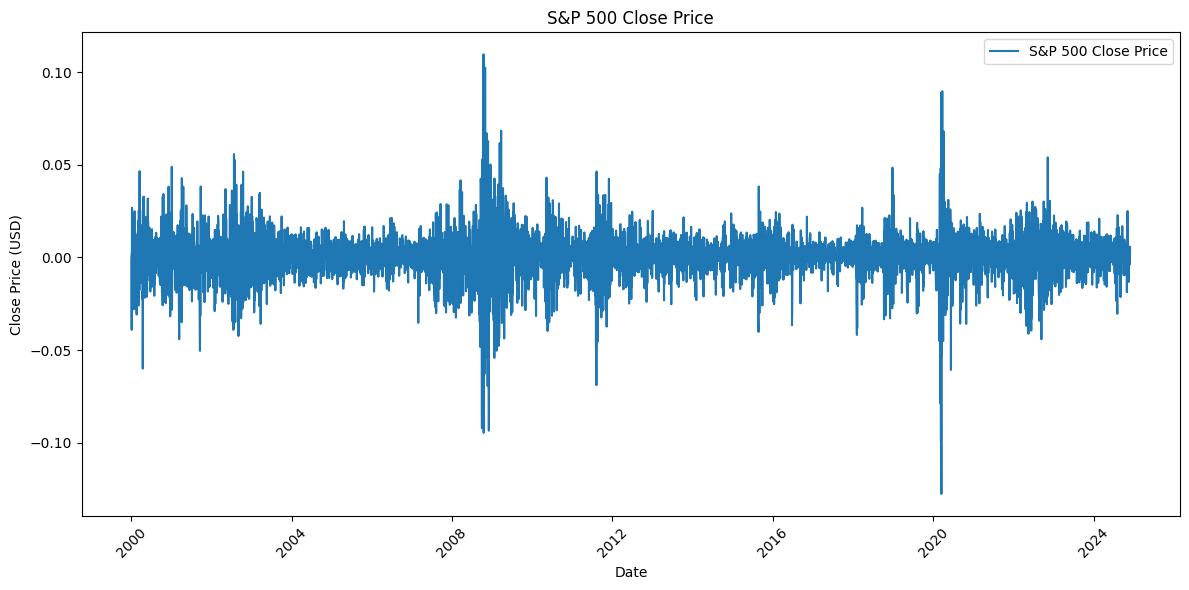

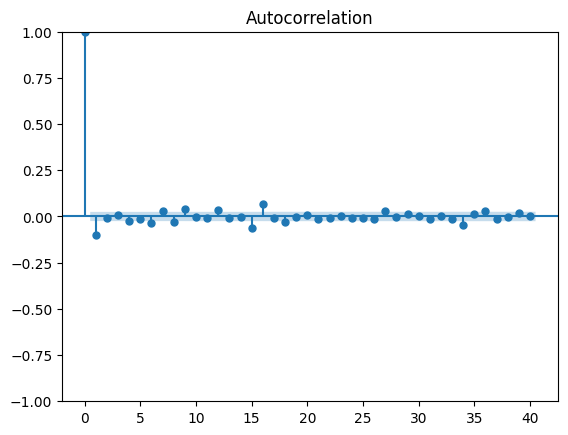

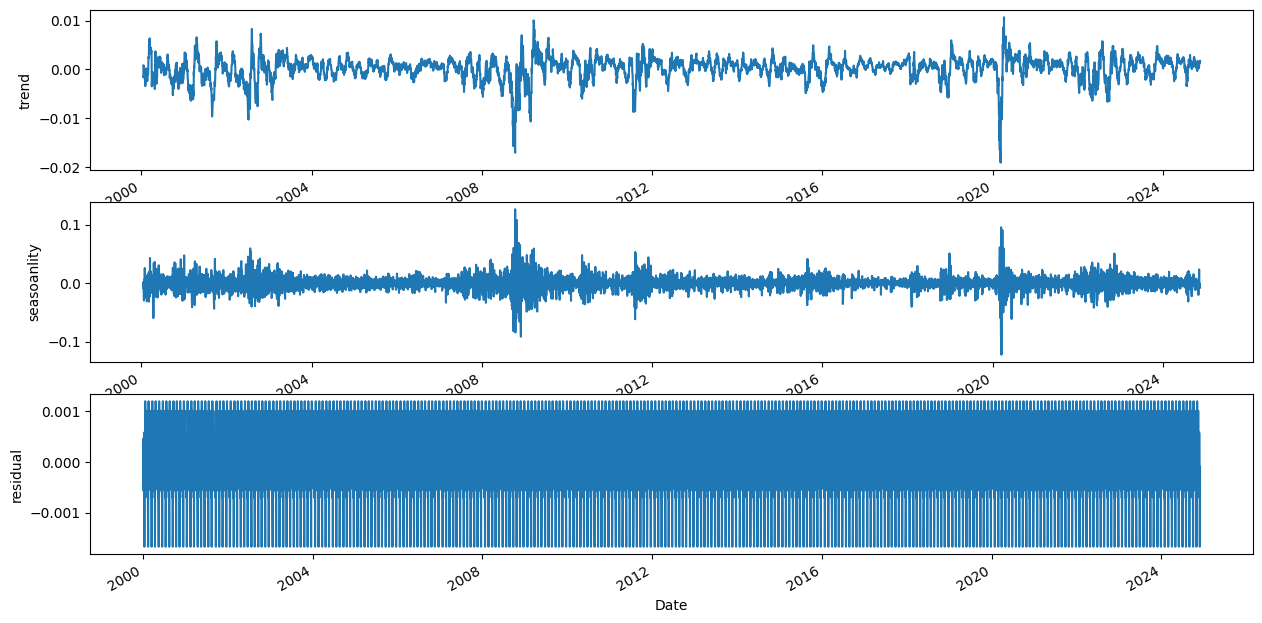

In [3]:
#compute log returns
sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
#sp500_data.dropna(inplace = True)
sp500_data.fillna(0, inplace=True)


#save log returns
  drive.mount("/content/gdrive")
  df_log_returns = sp500_data['Log Return'].copy()
  df_log_returns.index = sp500_data.index
  file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/log_returns.csv'
  df_log_returns.to_csv(file_path, index=True)


#test stationarity with the Augmented Dickey-Fuller (ADF) test
result = adfuller(sp500_data['Log Return'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary


#test normality with Normality test
stat, p = normaltest(sp500_data['Close'])
print(f"Normal test Statistic: {stat[0]:.3f}")
print(f"P-value: {p[0]:.3f}") # If the p-value is more than 0.05, the series is normally distributed


sp500_data['Log Return'].hist(bins=50, figsize=(10, 8))
plt.show()

sm.qqplot(sp500_data['Log Return'], line='s')
plt.show()


#visualise
plt.figure(figsize=(12, 6))
sns.lineplot(x=sp500_data.index, y=sp500_data['Log Return'], label="S&P 500 Close Price")
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.show()


# Plot the ACF
plot_acf(sp500_data['Log Return'], lags=40)  # You can adjust the number of lags
plt.show()


#decompose time series
res = seasonal_decompose(sp500_data['Log Return'], model = "additive",period = 21)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

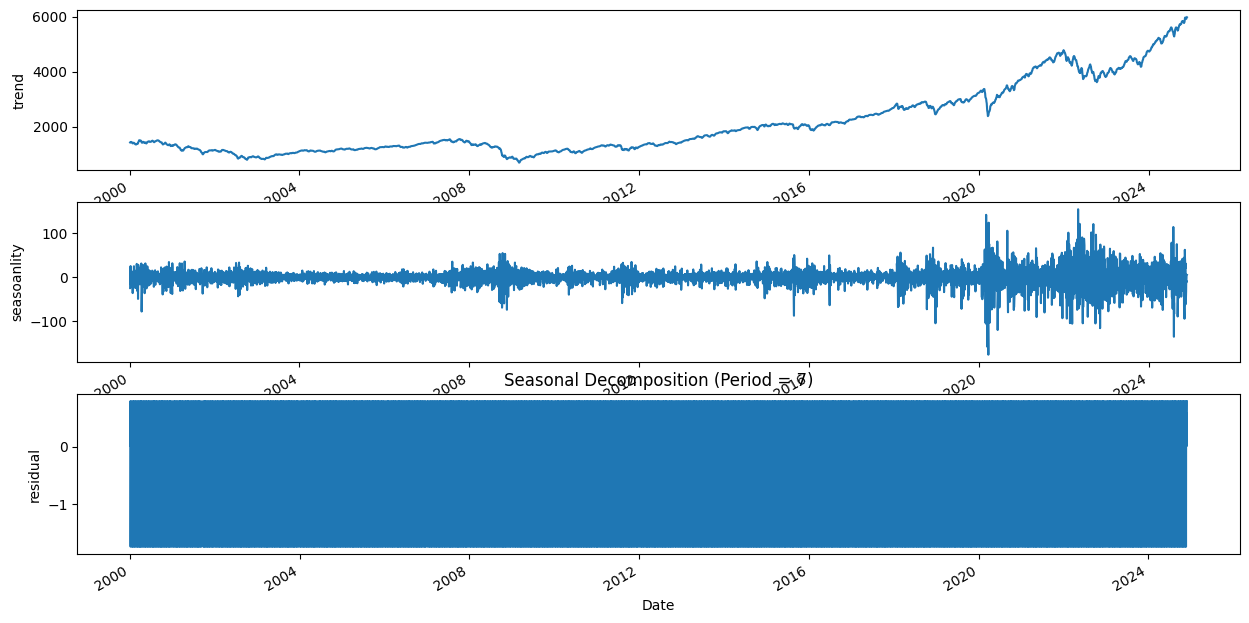

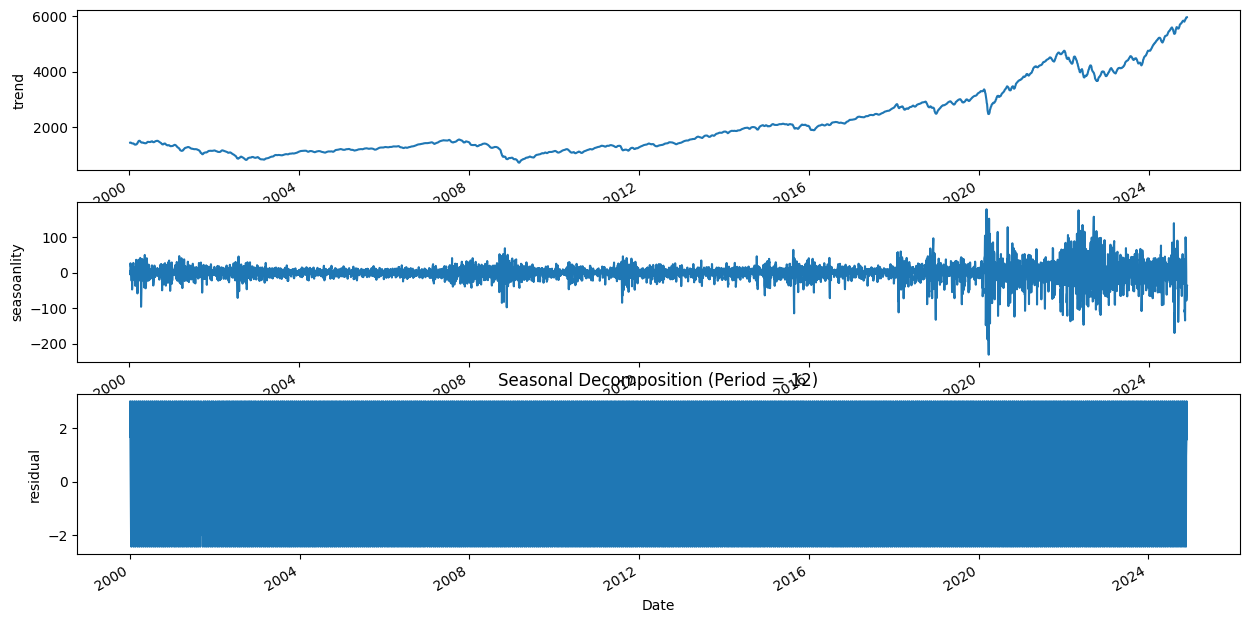

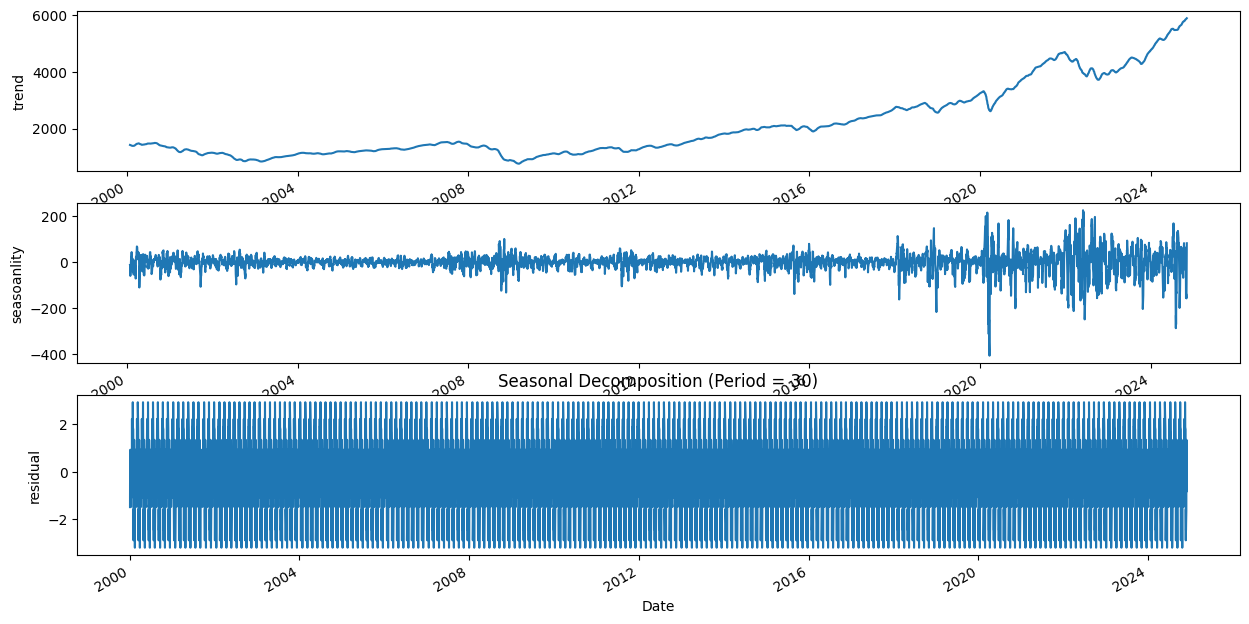

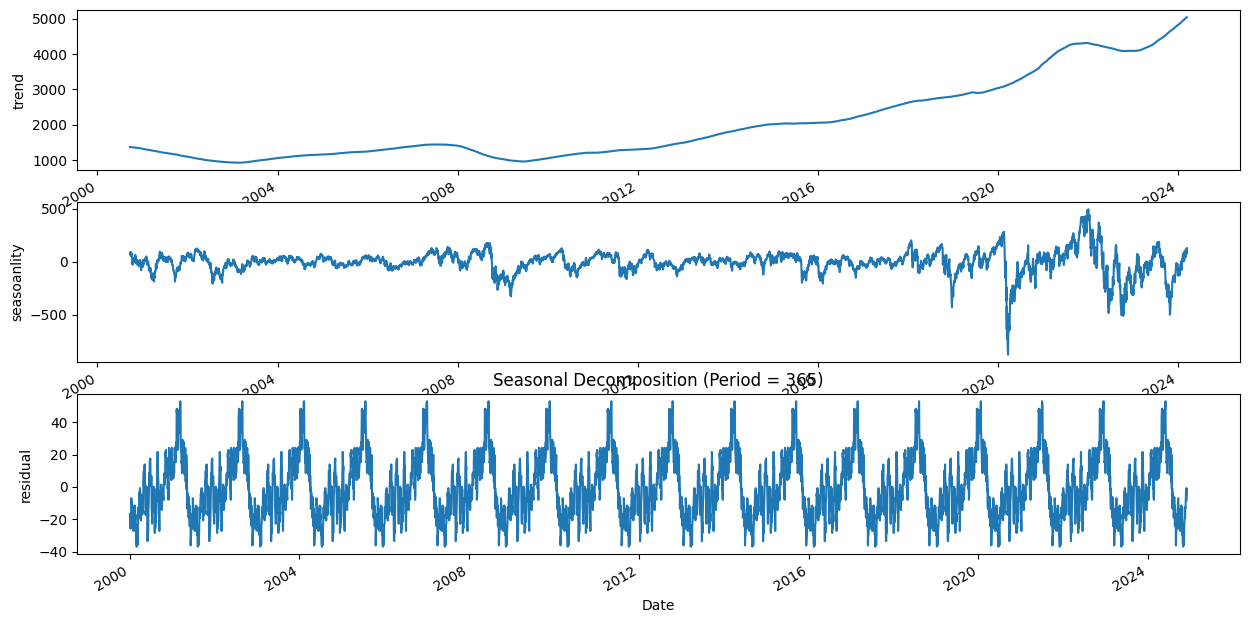

In [4]:
periods = [7, 12, 30, 365]  # Example: weekly, monthly, 30-day, yearly
for period in periods:
  res = seasonal_decompose(sp500_data['Close'], model = "additive",period = period)
  fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
  res.trend.plot(ax=ax1,ylabel = "trend")
  res.resid.plot(ax=ax2,ylabel = "seasoanlity")
  res.seasonal.plot(ax=ax3,ylabel = "residual")
  plt.title(f"Seasonal Decomposition (Period = {period})")
  plt.show()

##ARIMA model
The ARIMA model has three key parameters:

* p: The order of the autoregressive (AR) term.
* d: The degree of differencing to make the series stationary.
* q: The order of the moving average (MA) term.

In [5]:
!pip install arm-mango


In [6]:
#libraries
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
from google.colab import drive
from joblib import Parallel, delayed
import time

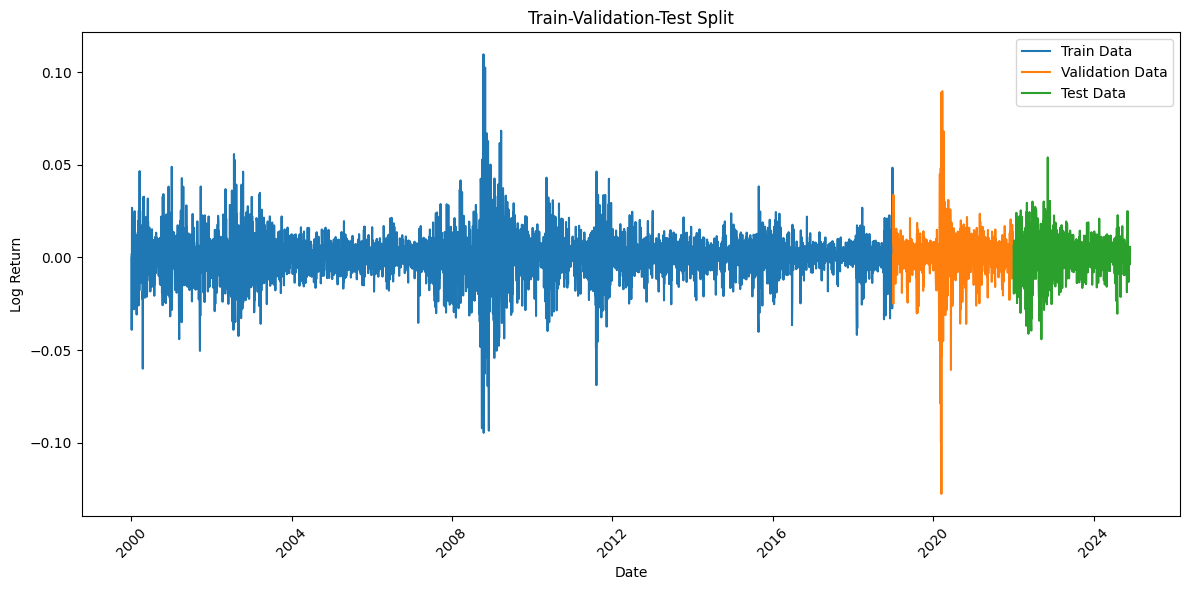

In [7]:
#train / validation / test split
train_data = sp500_data['Log Return'].loc[: '2018']
val_data = sp500_data['Log Return'].loc['2019': '2021']
test_data = sp500_data['Log Return'].loc['2022':]


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data.values, label="Train Data")
sns.lineplot(x=val_data.index, y=val_data.values, label="Validation Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
plt.title('Train-Validation-Test Split')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

###Find the best hyperparameter using Bayesian Optimization

In [ ]:
#define objective function
def arima_objective_function (args_list):
  global train_data, test_data
  params_evaluated = [] # list that will hold the parameters tested
  results = [] # thi will hold the MSE values for each parameter set.

  for params in args_list:
      try:
          p,d,q = params['p'],params['d'], params['q']
          trend = params['trend']
          model = ARIMA(train_data, order=(p,d,q), trend = trend).fit() #train ARIMA model with the subset of hyperparameters
          predictions = model.forecast(steps=len(test_data)) #get forecast
          mse = mean_squared_error(test_data, predictions) #compute mse
          params_evaluated.append(params)
          results.append(mse)
      except:
          #print(f"Exception raised for {params}")
          #pass
          params_evaluated.append(params)
          results.append(1e5)  #if an error occurs the function appends a very large MSE (1e5) to results, which serves as a penalty for that parameter combination.

      #print(params_evaluated, mse)
  return params_evaluated, results


#define the search space
param_space = dict(p= range(6, 30),  #use of range to ensure integers
                   d=[0],
                   q =range(6, 30),
                   trend = ['n']
                  )


#run optimization
conf_Dict = {'num_iteration': 50 , 'initial_random' : 5}  #configuration dictionary , number of iteration
tuner = Tuner(param_space, arima_objective_function, conf_Dict) # Initialize Tuner
results = tuner.minimize()  #Bayesian optimization to minimize the objective function
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, train_data, val_data):
      self.conf_dict = configuration_params  # parameters to configure the Tuner
      self.njobs = njobs
      self.train_data = train_data
      self.val_data = val_data
      self.space = dict(p= range(6, 30), # Definition of the search space of the algorithm
                        d=[0],
                        q =range(6, 30),  #use of range to ensure integers
                        trend = ['t']
                        )


  #This is the loss function that mango optimizes
  def arima_objetive_function(self, **params):
    params_evaluated = [] # list that will hold the parameters tested
    results = [] # thi will hold the MSE values for each parameter set.

    try:
      p,d,q = params['p'],params['d'], params['q']
      trend = params['trend']
      model = ARIMA(self.train_data, order=(p,d,q), trend = trend).fit() #train ARIMA model with the subset of hyperparameters
      predictions = model.forecast(steps=len(self.val_data)) #get forecast
      mse = mean_squared_error(self.val_data, predictions) #compute mse
      params_evaluated.append(params)
      results.append(mse)
    except:
      #print(f"Exception raised for {params}")
      #pass
      params_evaluated.append(params)
      results.append(1e5)  #if an error occurs the function appends a very large MSE (1e5) to results, which serves as a penalty for that parameter combination.
    return results


  def _objective2(self, params_batch): #to perform bayesian optimization in parallel
      global parameters
      results_batch = Parallel(self.njobs, backend="multiprocessing")(delayed(self.arima_objetive_function)(**params) for params in params_batch)
      rmse = [result for result in results_batch]
      return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


 # Parallel Bayesian optimization
config_params = {'num_iteration': 50, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, train_data=train_data, val_data=val_data)
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')

# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimisation in parallel takes 90.03256151676177 minutes.
best parameters: {'d': 0, 'p': 8, 'q': 13, 'trend': 't'}
best accuracy: 0.0002022716167783855


###ARIMA Predictions

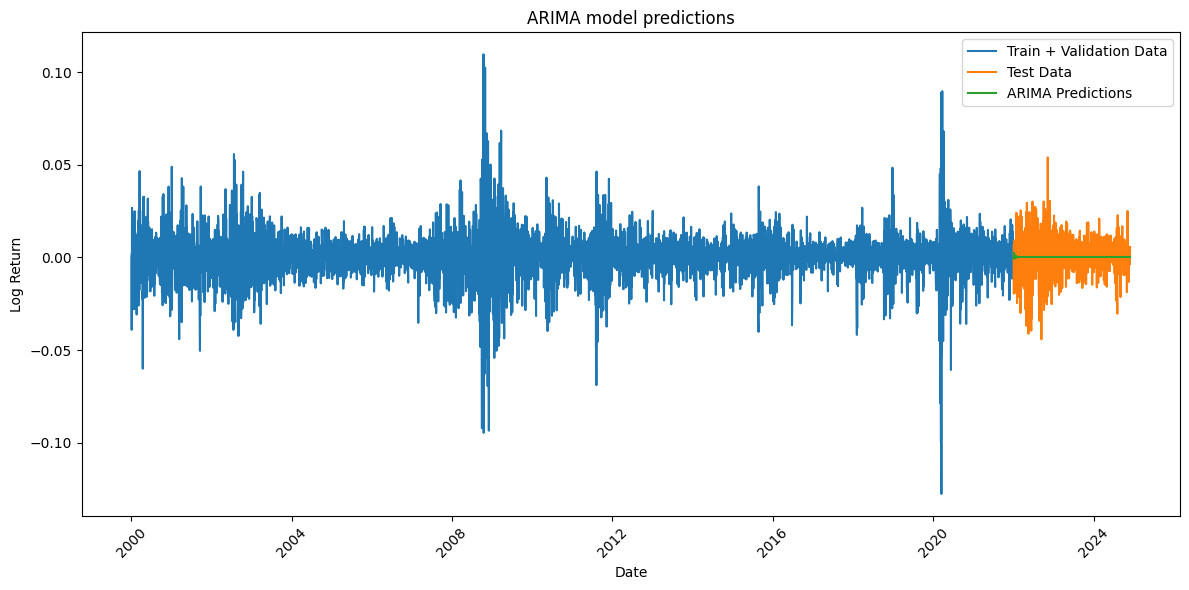

MSE: 0.00012269300985305882
RMSE 0.011076687675160785
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
# best_params = {'d': 0, 'p': 6, 'q': 6, 'trend': 'n'}
best_params = {'d': 0, 'p': 8, 'q': 13, 'trend': 'c'}
train_val_data = pd.concat([train_data, val_data])  #combine train and validation data
model = ARIMA(train_val_data, order=(best_params['p'], best_params['d'], best_params['q']), trend=best_params['trend']).fit()  #train model
forecast = model.forecast(steps=len(test_data)) ##predict


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.values, label="Train + Validation Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
sns.lineplot(x=test_data.index, y=forecast, label="ARIMA Predictions")
plt.title('ARIMA model predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute MSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)


#save arima predictions
drive.mount("/content/gdrive")
df_arima_predictions = pd.Series(forecast)
df_arima_predictions.index = sp500_data.index[len(train_val_data):]
file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/arima_predictions.csv'
df_arima_predictions.to_csv(file_path, index=True)

arima model: (8, 0, 13) c
MSE: 0.00014961930860154214
RMSE: 0.012231897179159991
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


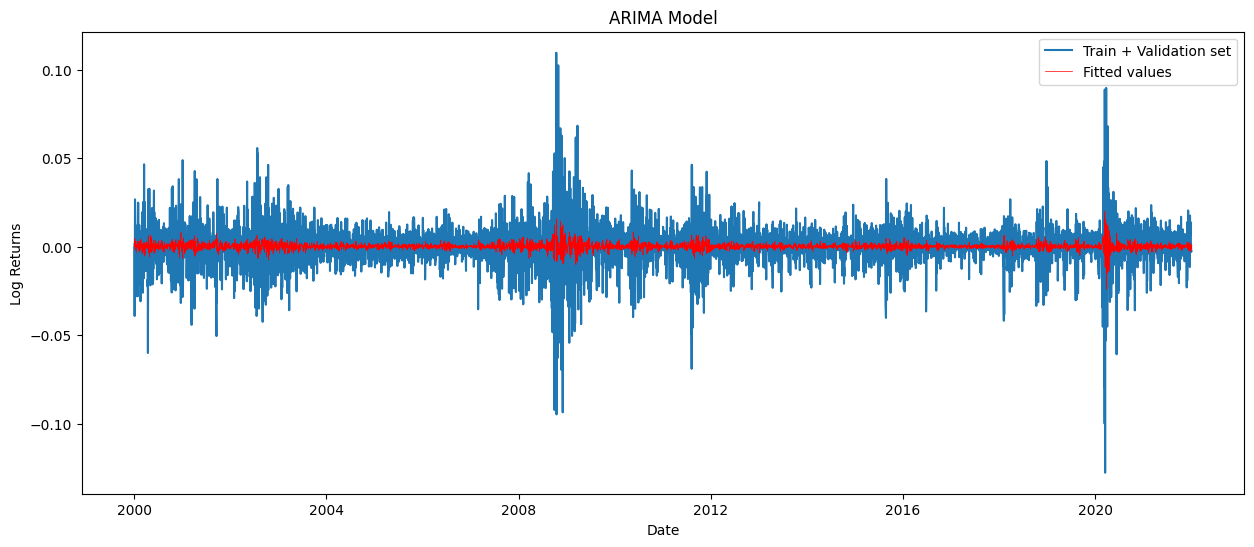

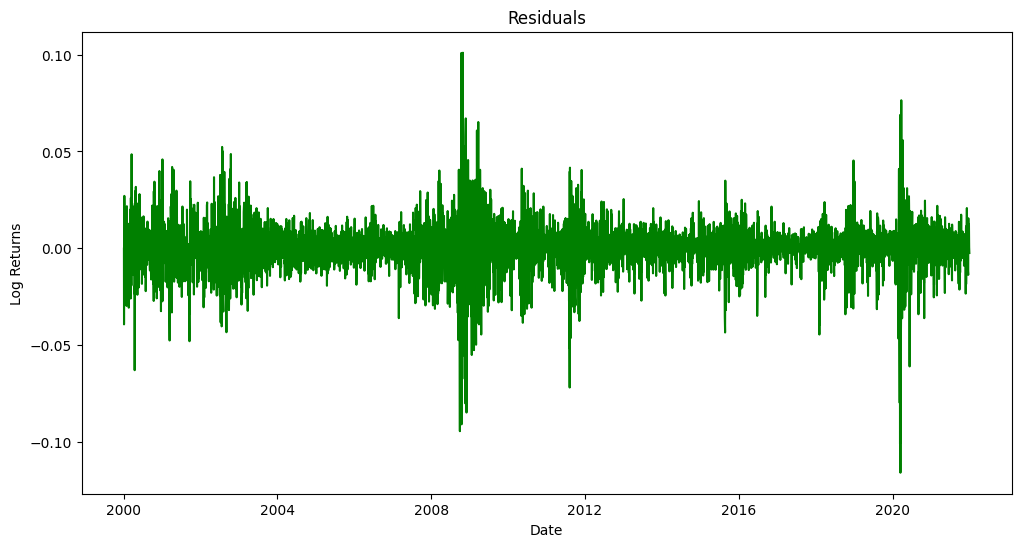

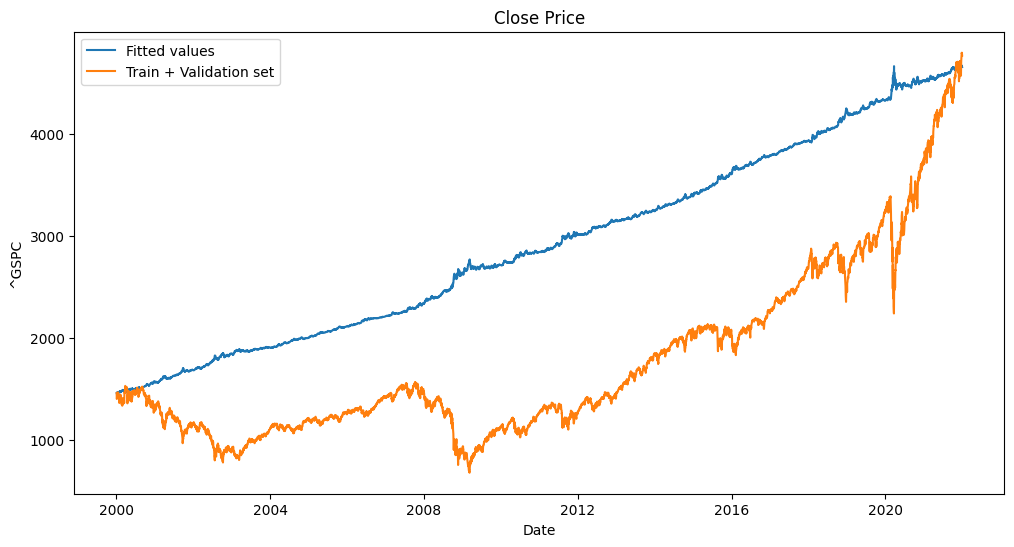

In [54]:
def plot_arima(data, order , trend):
  print('arima model:', order, trend)
  model = ARIMA(data, order=order, trend = trend)
  results = model.fit()
  residuals = results.resid  #residuals
  mse = mean_squared_error(data, results.fittedvalues)
  rmse = np.sqrt(mse)
  print('MSE:', mse)
  print('RMSE:', rmse)


  #save residuals on google
  drive.mount("/content/gdrive")
  df_residuals = sp500_data['Log Return'].copy()
  file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/residuals.csv'
  df_residuals.to_csv(file_path, index=True)


  #log return prediction on train + val set
  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(6)
  plt.plot(data, label = "Train + Validation set")
  plt.plot(results.fittedvalues, color='red', label = "Fitted values", linewidth=0.5)
  plt.legend()
  plt.title('ARIMA Model')
  plt.xlabel('Date')
  plt.ylabel('Log Returns')
  plt.show()


  #residuals
  plt.figure(figsize=(12, 6))
  plt.plot(results.resid, color = 'green', label = "Residuals")
  plt.title('Residuals')
  plt.xlabel('Date')
  plt.ylabel('Log Returns')
  plt.show()

  #convert log returns back into close prices
  initial_price = sp500_data['Close']['^GSPC'].iloc[0]
  predicted_close_price = initial_price * np.exp(results.fittedvalues.cumsum())
  plt.figure(figsize=(12, 6))
  plt.title('ARIMA Model results using close prices')
  sns.lineplot(data=predicted_close_price, label="Fitted values")
  sns.lineplot(x=sp500_data[:len(train_val_data)].index, y=sp500_data['Close'][:len(train_val_data)].squeeze(), label="Train + Validation set")
  plt.title('Close Price')
  plt.xlabel('Date')
  plt.show



#train ARIMA on test set and compute residuals
#best_params = {'d': 0, 'p': 10, 'q': 12, 'trend': 't'} #best model found using Bayesian Optimization
best_params = {'d': 0, 'p': 8, 'q': 13, 'trend': 'c'}

order=(best_params['p'], best_params['d'], best_params['q'])
trend=best_params['trend']
plot_arima(train_val_data, order, trend)


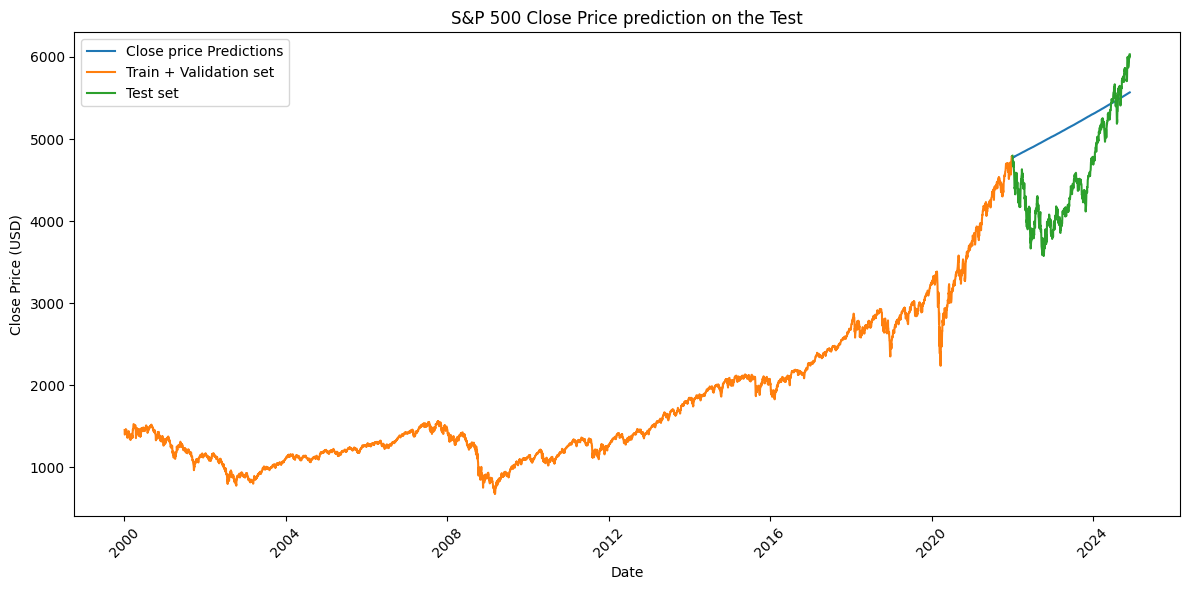

In [52]:
forecast = pd.Series(forecast)
forecast.index = sp500_data.index[len(train_val_data):]
lista = pd.concat([train_val_data, forecast])
pd.set_option('display.float_format', '{:.6f}'.format)
initial_price = sp500_data['Close']['^GSPC'].iloc[0]
predicted_close_price = initial_price * np.exp(lista.cumsum())
predicted_close_price


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(data = predicted_close_price[len(train_val_data):], label="Close price Predictions")
sns.lineplot(data = sp500_data['Close']['^GSPC'][:len(train_val_data)], label="Train + Validation set")
sns.lineplot(x=sp500_data[len(train_val_data):].index, y=sp500_data['Close'][len(train_val_data):].squeeze(), label="Test set")
plt.title('S&P 500 Close Price prediction on the Test')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


##Naive estimator

MSE: 0.00012262366886485636
RMSE 0.011073557191113267


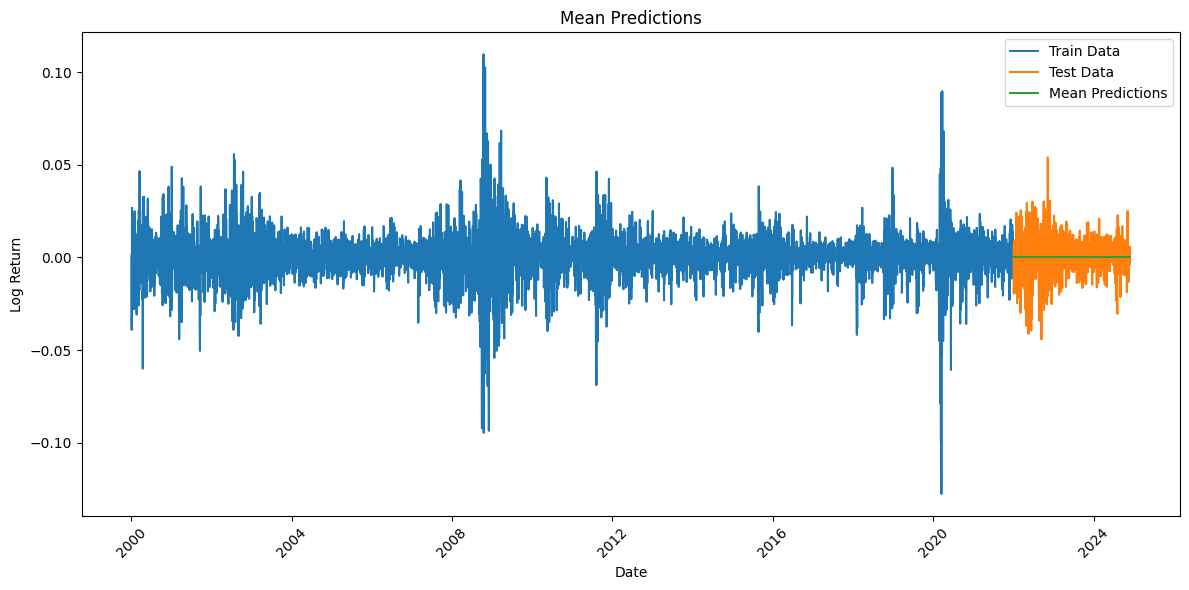

In [15]:
class naive_estimator:
    def __init__(self):
        self.mean_value = None  # Initialize mean

    def fit(self, train_data):
        self.mean_value = np.mean(train_data)

    def predict(self, test_data):
        return np.full(len(test_data), self.mean_value)  # Creates array of mean values


mean_esitmator = naive_estimator()
mean_esitmator.fit(train_val_data)
predictions = mean_esitmator.predict(test_data)

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.values, label="Train Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
sns.lineplot(x=test_data.index, y=predictions, label="Mean Predictions")
plt.title('Mean Predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

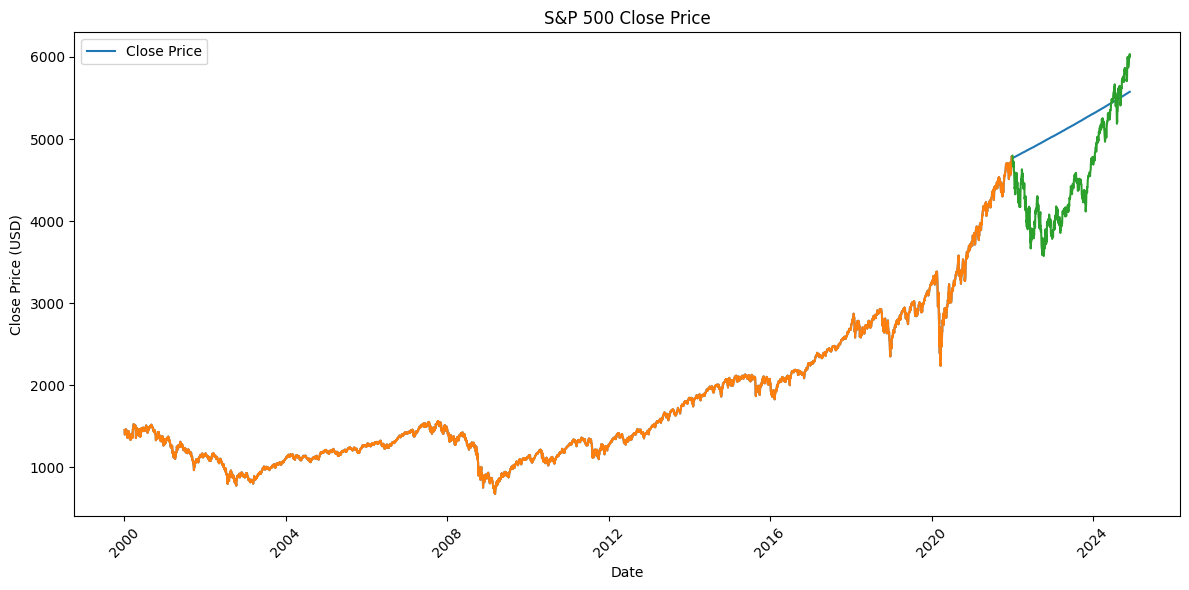

In [18]:
lista = list(train_val_data)
lista.extend(predictions)
lista = pd.Series(lista)
pd.set_option('display.float_format', '{:.6f}'.format)

initial_price = sp500_data['Close']['^GSPC'].iloc[0]
predicted_close_price = initial_price * np.exp(lista.cumsum())
predicted_close_price


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=sp500_data.index, y=predicted_close_price, label="Predictions")
sns.lineplot(x=sp500_data[:len(train_val_data)].index, y=sp500_data['Close'][:len(train_val_data)].squeeze(), label="Train set")
sns.lineplot(x=sp500_data[len(train_val_data):].index, y=sp500_data['Close'][len(train_val_data):].squeeze(), label="Test set")
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend( labels=["Close Price"])
plt.show()


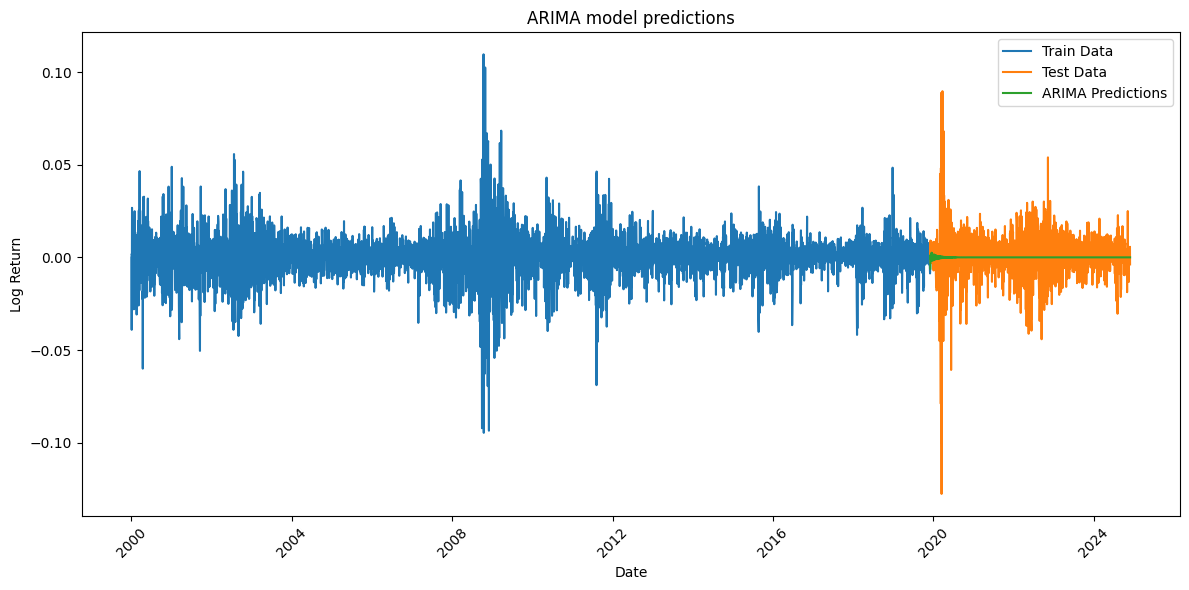

MSE: 0.00018188906736041422
RMSE 0.013486625499375826


In [20]:
df_differenced = sp500_data['Log Return'].copy().diff()
train_data_diff, test_data_diff = df_differenced[:train_size], df_differenced[train_size:]


best_params = {'d': 0, 'p': 10, 'q': 12, 'trend': 'n'}

model = ARIMA(train_data_diff, order=(best_params['p'], best_params['d'], best_params['q']), trend=best_params['trend']).fit()  #train model
forecast = model.forecast(steps=len(test_data_diff)) ##predict


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data.values, label="Train Data")
sns.lineplot(x=test_data.index, y=test_data.values, label="Test Data")
sns.lineplot(x=test_data.index, y=forecast, label="ARIMA Predictions")
plt.title('ARIMA model predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#compute MSE
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE', rmse)

##Difference time series

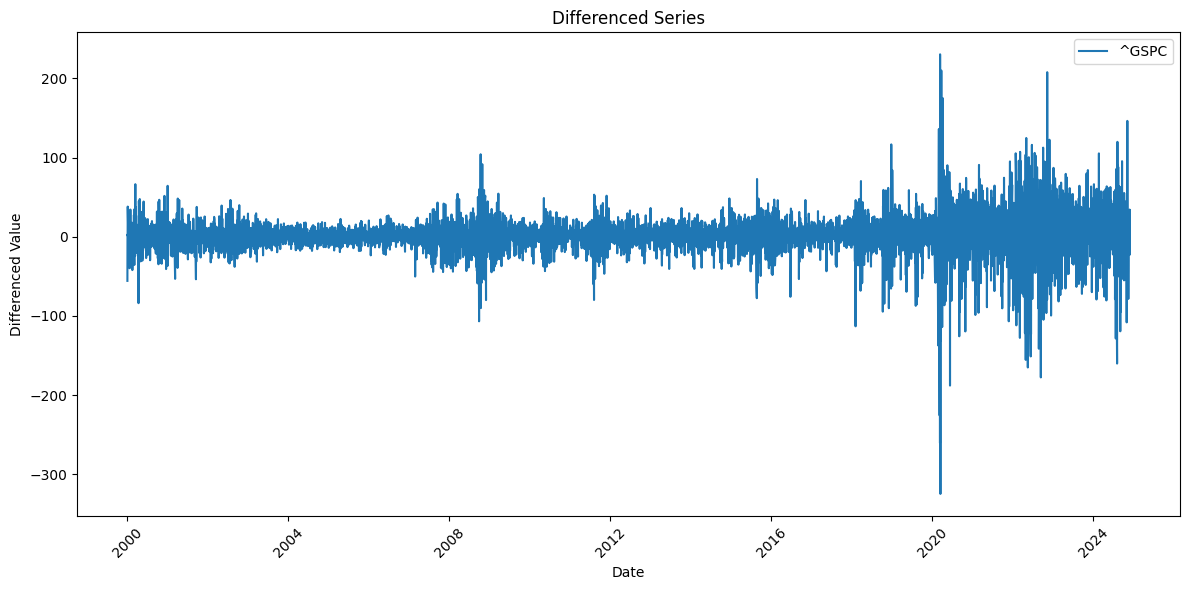

In [36]:
df_differenced = sp500_data['Close'].copy().diff()


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_differenced)
plt.title('Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

In [53]:
best_params = {'d': 0, 'p': 8, 'q': 13, 'trend': 'c'}
model = ARIMA(train_val_data, order=(best_params['p'], best_params['d'], best_params['q']), trend=best_params['trend'])
results = model.fit()
residuals = results.resid  #residuals
residuals

,0
Date,
2000-01-03,-0.000211
2000-01-04,-0.039333
2000-01-05,-0.002698
2000-01-06,0.000424
2000-01-07,0.027058
...,...
2021-12-27,0.012450
2021-12-28,0.001661
2021-12-29,0.000442
